In [6]:
%matplotlib inline

import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict

from resspect import cosmo_metric_utils as cmu

In [7]:
# read DDF data
v = '1'
df = pd.read_csv('/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data/DDF/v' + v + '/summary_stats.csv' )

In [15]:
# read WFD data

remap_dict = OrderedDict({
                              'perfect3000': 'Perfect', 
                              'fiducial3000': 'Fiducial', 
                              'random3000': 'Random',
                              '72SNIa28SNII': 'SN-II 28',
                              '75SNIa25SNII': 'SN-II 25', 
                              '90SNIa10SNII': 'SN-II 10',
                              '95SNIa5SNII': 'SN-II 5',
                              '98SNIa2SNII': 'SN-II 2',
                              '99SNIa1SNII': 'SN-II 1',
                              '90SNIa10SNIbc': 'SN-Ibc 10',
                              '95SNIa5SNIbc': 'SN-Ibc 5',
                              '98SNIa2SNIbc': 'SN-Ibc 2',
                              '99SNIa1SNIbc': 'SN-Ibc 1',
                              '75SNIa25SNIax': 'SN-Iax 25',
                              '90SNIa10SNIax': 'SN-Iax 10',
                              '95SNIa5SNIax': 'SN-Iax 5',
                              '98SNIa2SNIax': 'SN-Iax 2',
                              '99SNIa1SNIax': 'SN-Iax 1',
                              '95SNIa5SNIa-91bg': 'SN-Ia-91bg 5',
                              '98SNIa2SNIa-91bg': 'SN-Ia-91bg 2',
                              '99SNIa1SNIa-91bg': 'SN-Ia-91bg 1',
                              '95SNIa5AGN': 'AGN 5',
                              '98SNIa2AGN': 'AGN 2',
                              '99SNIa1AGN': 'AGN 1',
                              '99.6SNIa0.4TDE': 'TDE 0.4',
                              '99.7SNIa0.3CART': 'CART 0.3',
                  })

remap_dict_ddf = OrderedDict({
                          'perfect3000': 'Perfect', 
                          'fiducial3000': 'Fiducial', 
                          'random3000': 'Random',
                          '72SNIa28SNII': 'SN-II 28',
                          '75SNIa25SNII': 'SN-II 25', 
                          '90SNIa10SNII': 'SN-II 10',
                          '95SNIa5SNII': 'SN-II 5',
                          '98SNIa2SNII': 'SN-II 2',
                          '99SNIa1SNII': 'SN-II 1',
                          '95SNIa5SNIbc': 'SN-Ibc 5',
                          '98SNIa2SNIbc': 'SN-Ibc 2',
                          '99SNIa1SNIbc': 'SN-Ibc 1',
                          '86SNIa14SNIax': 'SN-Iax 14',
                          '90SNIa10SNIax': 'SN-Iax 10',
                          '95SNIa5SNIax': 'SN-Iax 5',
                          '98SNIa2SNIax': 'SN-Iax 2',
                          '99SNIa1SNIax': 'SN-Iax 1',
                          '99.1SNIa0.9CART': 'CART 0.9',
                          '99.8SNIa0.2SNIa-91bg': 'SN-Ia-91bg 0.2',
                          '99.9SNIa0.1AGN': 'AGN 0.1',
              })

all_shapes = {'SNIa-91bg': 'o',
              'SNIax': 's',
              'SNII': 'd',
              'SNIbc': 'X',
              'AGN': '^',
              'TDE': '<',
              'CART': 'v'}

color_nums = np.array([1, 1, 1,                    # Special
                       28, 25, 10, 5, 2, 1,        # II
                       10, 5, 2, 1,                # Ibc
                       25, 10, 5, 2, 1,            # Iax
                       5, 2, 1,                    # 91bg
                       5, 2, 1,                    # AGN
                       1,                          # TDE
                       1,                          # CART
                       ]) 

color_nums_ddf = np.array([1, 1, 1,               # Special
                       28, 25, 10, 5, 2, 1,   # II
                       5, 2, 1,               # Ibc
                       14, 10, 5, 3, 2, 1,    # Iax
                       1,                     # CART
                       1,                     # 91bg
                       1,                     # AGN
                          ]) 

# Color map
rainbow = cm = plt.get_cmap('plasma_r')
cNorm  = colors.LogNorm(vmin=1, vmax=52) #colors.Normalize(vmin=0, vmax=50)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
color_map = scalarMap.to_rgba(np.arange(1, 52))

In [11]:
# list of numbered files 
files = glob.glob('/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data/WFD/v*/summary_stats.csv')

summary_dict = {}

summary_dict['fom3'] = {}
summary_dict['KLD'] = {}
summary_dict['Wasserstein'] = {}
summary_dict['FM'] = {}
summary_dict['wfit'] = {}
summary_dict['wfit_std'] = {}
summary_dict['stan'] = {}
summary_dict['stan_std'] = {}


# j -> index from 0 to number of cases
# a -> case
# c -> contamination percentage. Cases with more than one contaminante are set to 1

for j, (a, c) in enumerate(zip(remap_dict, color_nums)):

    summary_dict['fom3'][a] = []
    summary_dict['KLD'][a] = []
    summary_dict['Wasserstein'][a] = []
    summary_dict['FM'][a] = []
    summary_dict['wfit'][a] = []
    summary_dict['wfit_std'][a] = []
    summary_dict['stan'][a] = []
    summary_dict['stan_std'][a] = []
    
    # f -> list of numbered files
    for f in files:
        
        df_t = pd.read_csv(f)
        
        if a in df_t['case'].values:
            summary_dict['fom3'][a].append(df_t['fom3'].loc[df_t['case'] == a].values[0])
            kld = df_t['KLD'].loc[df_t['case'] == a].values[0]
            summary_dict['KLD'][a].append(np.log(max([kld,1])))
            summary_dict['Wasserstein'][a].append(df_t['EMD'].loc[df_t['case'] == a].values[0])
            summary_dict['wfit'][a].append(df_t['wfit_w_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['wfit_std'][a].append(df_t['wfit_wsig_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['stan'][a].append(df_t['stan_w_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['stan_std'][a].append(df_t['stan_wsig_lowz'].loc[df_t['case'] == a].values[0])
        
    for i in range(1,6):
        # Fisher
        dist_loc_base = '/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data/WFD/v' + str(i) + '/stan_input/' 
        
        df_fisher = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_perfect3000.csv')
        sig_perf = cmu.fisher_results(df_fisher['z'].values, df_fisher['muerr'].values)[0]

        df_ = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_'+ a + '.csv')
        sig = cmu.fisher_results(df_['z'].values, df_['muerr'].values)[0]
        summary_dict['FM'][a].append((sig[1]-sig_perf[1])/sig_perf[1])

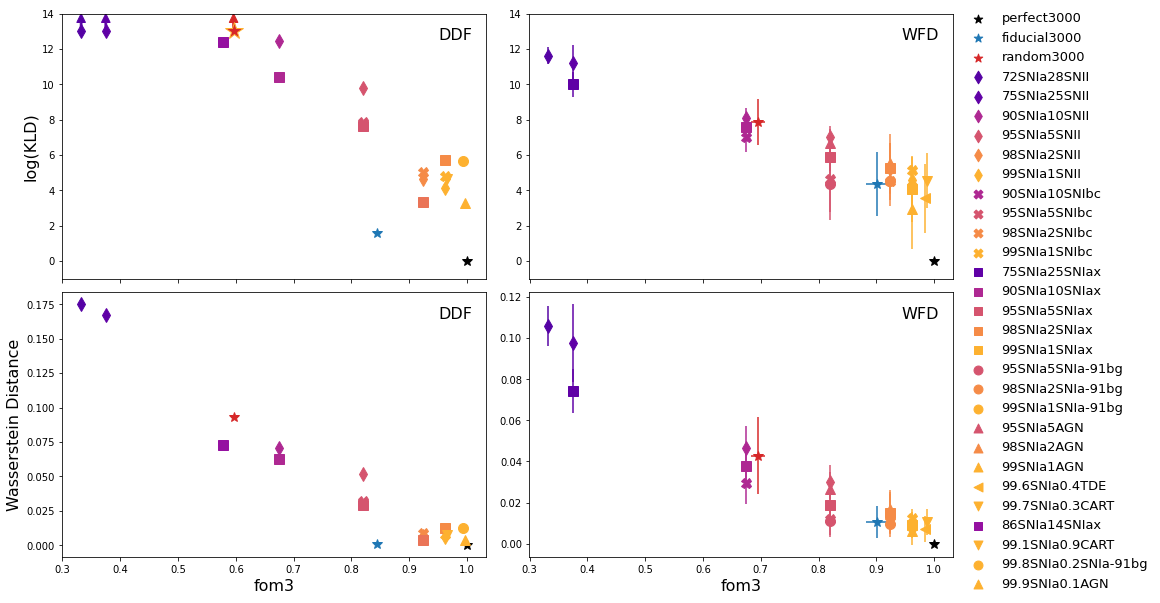

In [17]:
i = 0
tick_lbls = []
i_list = []

all_shapes['Perfect'] = '*'
all_shapes['Fiducial'] = '*'
all_shapes['Random'] = '*'


fig2, axes2 = plt.subplots(2, 2, figsize=(16,10), sharex=True)

ax1 = axes2[0][1]
ax2 = axes2[1][1]

ax3  = axes2[0][0]
ax4 = axes2[1][0]

legend = True
legends_done = []
legend_objs = []

for j, (a, c) in enumerate(zip(remap_dict, color_nums)):
    
    class_ = str.split(remap_dict[a])[0]
    
    flag1 = 'perfect' in a or 'random' in a
    flag_special = flag1 or 'fiducial' in a

    if '91bg' in class_:
        class_ = 'SNIa-91bg'
    else:
        class_ = class_.replace('-', '')

        
    if 'fiducial' in a:
        mfc = 'tab:blue'
    elif 'random' in a:
        mfc = 'tab:red'
    elif 'perfect' in a:
        mfc = 'k'
    else:
        mfc = color_map[c]
    
    fom3_wfd =  np.array([np.mean(summary_dict['fom3'][a])])
    fom3_sig_wfd = np.array([np.std(summary_dict['fom3'][a], ddof=1)])
    
    kld_wfd = np.array(np.mean(summary_dict['KLD'][a]))
    kld_st_wfd = np.array(np.std(summary_dict['KLD'][a], ddof=1))
    
    wsd_wfd = np.array([np.mean(summary_dict['Wasserstein'][a])])
    wsd_st_wfd = np.array([np.std(summary_dict['Wasserstein'][a], ddof=1)])    
    
    if flag_special:
        ax1.errorbar(fom3_wfd, kld_wfd, xerr=fom3_sig_wfd, yerr=kld_st_wfd, color=mfc, ms=10, marker=all_shapes[class_])
        ax2.errorbar(fom3_wfd, wsd_wfd, xerr=fom3_sig_wfd, yerr=wsd_st_wfd, color=mfc, ms=10, marker=all_shapes[class_])
    else:
        ax1.errorbar(fom3_wfd, kld_wfd, xerr=fom3_sig_wfd, yerr=kld_st_wfd, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_])
        ax2.errorbar(fom3_wfd, wsd_wfd, xerr=fom3_sig_wfd, yerr=wsd_st_wfd, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_])
        
    if a not in legends_done:
        legends_done.append(a)
        l1 = ax1.scatter([],[], color=mfc, s=80, marker=all_shapes[class_], label=a)
        legend_objs.append(l1)
        
        
for j, (a, c) in enumerate(zip(remap_dict_ddf, color_nums_ddf)):  
    
    class_ = str.split(remap_dict_ddf[a])[0]
    
    flag1 = 'perfect' in a or 'random' in a
    flag_special = flag1 or 'fiducial' in a

    if '91bg' in class_:
        class_ = 'SNIa-91bg'
    else:
        class_ = class_.replace('-', '')

    if 'fiducial' in a:
        mfc = 'tab:blue'
    elif 'random' in a:
        mfc = 'tab:red'
    elif 'perfect' in a:
        mfc = 'k'
    else:
        mfc = color_map[c]
            
    fom3_ddf = df['fom3'].loc[df['case'] == a].values
    
    if 'perfect' in a:
        kld_ddf = 0
        wsd_ddf = 0
    else:
        kld_ddf = np.log(df['KLD'].loc[df['case'] == a].values)
        wsd_ddf = df['EMD'].loc[df['case'] == a].values
    
    
    if flag_special:
        ax4.plot(fom3_ddf, wsd_ddf, color=mfc, ms=10, marker=all_shapes[class_])
        
        # case where KLD explodes
        if 'random' in a:
            ax3.plot(fom3_ddf, [13], color=color_map[c], mfc=mfc, ms=18, marker=all_shapes[class_])
            ax3.arrow(fom3_ddf[0], 13, 0, 1, width=0.003, color=mfc, length_includes_head=True, head_width=0.015, head_length=0.5)
        else:
            ax3.plot(fom3_ddf, kld_ddf, color=mfc, ms=10, marker=all_shapes[class_])
    else:
        ax4.plot(fom3_ddf, wsd_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_])
    
        # cases where KLD explodes
        if '25SNII' in a or '28SNII' in a:
            lims = ax3.get_ylim()
            ax3.plot(fom3_ddf, [13], color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_])
            ax3.arrow(fom3_ddf[0], 13, 0, 1, width=0.003, color=mfc, length_includes_head=True, head_width=0.015, head_length=0.5)
            
        else:
            ax3.plot(fom3_ddf, kld_ddf, color=color_map[c], mfc=mfc, ms=10, marker=all_shapes[class_])  
      
    
    if legend:
        field_label, = ax1.plot([],[], label='WFD', color='white')
        
        ax2.plot([],[], label='WFD', color='white')
        ax2.legend(frameon=False, fontsize=16)
        
        ax3.plot([],[], label='DDF', color='white')
        ax3.legend(frameon=False, fontsize=16)
        
        ax4.plot([],[], label='DDF', color='white')
        ax4.legend(frameon=False, fontsize=16)
        
        legend = False
    
    
    ax2.set_xlabel('fom3', fontsize=16)
    ax4.set_xlabel('fom3', fontsize=16)
    ax4.set_ylabel('Wasserstein Distance', fontsize=16)
    ax3.set_ylabel('log(KLD)', fontsize=16)
    #ax3.set_ylim(10, 6)
    
    if a not in legends_done:
        legends_done.append(a)
        l1 = ax1.scatter([],[], color=mfc, s=80, marker=all_shapes[class_], label=a)
        legend_objs.append(l1)

ax3.set_ylim(-1, 14)
ax1.set_ylim(-1, 14)

field_legend = ax1.legend(handles=[field_label], loc='upper right', fontsize=16, frameon=False)
ax = ax1.add_artist(field_legend)


handles, labels = ax1.get_legend_handles_labels()
#order = [-3,-1,-2] + list(range(len(labels) - 3))
ax1.legend(handles=legend_objs, frameon=False, bbox_to_anchor=(1, 1.05), labelspacing=0.5, fontsize=13)
plt.subplots_adjust(hspace=0.05, left=0.051, wspace=0.1, right=0.825)

#plt.savefig('fom_KLD_WD.png')
plt.show()

In [28]:
density['DDF']

{6000: {'fiducial': <scipy.stats.kde.gaussian_kde at 0x7f444f5e8240>,
  'random': <scipy.stats.kde.gaussian_kde at 0x7f444f554da0>,
  'perfect': <scipy.stats.kde.gaussian_kde at 0x7f444f5544a8>}}